# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import entropy
from sklearn.metrics import silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
import workspace_utils
from workspace_utils import active_session
 
with active_session():
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
    # do long-running work here

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def val_ct(df,col):
    print(col)
    print(df[col].value_counts(dropna=False)/df.shape[0])
    try:
        print((df[col].value_counts(dropna=False)/df.shape[0]).loc[0] >0.9)
        return col
    except:
        print('exception')
    try:
        print((df[col].value_counts(dropna=False)/df.shape[0]).loc[-1] >0.9)
    except:
        print('exception')
    print()


def seg_entropy(df,col,dropna=True):
    ent=entropy(df[col].value_counts(dropna=dropna))
    #if  ent < 0.3:
    #if  ent > 1:
    #print(col,ent)
    return ent

def seg_orig_entropy(df,col):
    ent=entropy(df[col].value_counts(dropna=False))
    #if  ent < 0.3:
    if  ent > 1:
        print(col,ent)
        return col


In [4]:
def unimportant_cols(df,threshold=90):
    return df.columns[df.isnull().sum()/df.shape[0] *100.0 > threshold ].tolist()

def convert_cols(df,cols=['CAMEO_DEUG_2015','CAMEO_INTL_2015']):
    df.CAMEO_DEUG_2015=df.CAMEO_DEUG_2015.replace('X',-1).astype(float)
    df.CAMEO_INTL_2015=df.CAMEO_INTL_2015.replace('XX',-1).astype(float)
    df.CAMEO_DEU_2015=df.CAMEO_DEU_2015.replace(np.nan,-1).replace('XX',-1).astype('str').apply(lambda x: x if x=='-1' else x[0]+ str(ord(x[1])-65)).astype(float)
    
def replace_nan(df,cols):
    for col in cols:
        med=df[col].median()
        df[col]=df[col].replace(np.nan,med)
def replace_nan_with_val(df,cols,vals):
    for col,val in zip(cols,vals):
        df[col]=df[col].replace(np.nan,val)
def replace_nan_with_tuple(df,cols):
    for col,val in cols:
        df[col]=df[col].replace(np.nan,val)
def replace_global_nan(df,val):
    return df.replace(np.nan,val)

def get_dumm(df,cols):
    if cols is None:
        cols=df.columns.tolist()
    return pd.get_dummies(df,columns=cols,prefix=cols,prefix_sep='-',dummy_na=True)

def seg_pca(df,dim=100):
    pca=PCA(n_components=dim)
    X=pca.fit_transform(df)
    #sum=0
    #for val in pca.explained_variance_ratio_:
    #    sum+=val
    print("explained Variance")
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.sum())
    return pca,X

def kmeans(df,n_clusters=5,random_state=10,batch_size=1000):
    #kmeans=MiniBatchKMeans(initn_clusters,random_state,batch_size)
    kmeans=KMeans(init='k-means++',n_clusters=n_clusters,random_state=random_state)
    kmeans.fit(df)
    return kmeans

def not_null_cols(df):
    return df.columns[~df.isnull().any()].tolist()
    

In [5]:
#del_cols=unimportant_cols(azdias,90)
del_cols=[]
time_col='EINGEFUEGT_AM'
del_cols.append(time_col)
id_col='LNR'
del_cols.append(id_col)
Unimp_cols=['GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','D19_LETZTER_KAUF_BRANCHE']
del_cols.extend(Unimp_cols)
#del_cols.extend(chosen_cols)
del_cols=list(set(del_cols))
print(del_cols)
azdias=azdias.drop(del_cols,axis=1)
customers=customers.drop(del_cols,axis=1)



['EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR', 'LNR', 'GEBURTSJAHR', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']


In [6]:
ent_vals=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(azdias,col)
    if ent is not None:
        ent_vals.append(ent)
    
#print(ent_vals)

cust_ent_vals=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(customers,col)
    if ent is not None:
        cust_ent_vals.append(ent)
    
#print(cust_ent_vals)
chosen_dict={}
chosen_cols=[]
for i,col in enumerate((azdias.columns.tolist())):
    diff=(ent_vals[i] -cust_ent_vals[i]) /ent_vals[i] * 100
    diff=np.abs(diff)
    print(col,diff,'%',ent_vals[i],cust_ent_vals[i])
    if diff>5:
        chosen_cols.append(col)
        chosen_dict[col]=diff
    #if col.find("KBA") == -1:
    #    if np.abs(diff) <0.15:
    #        chosen_cols.append(col)
    #else:
    #     if np.abs(diff) <0.20:
    #        chosen_cols.append(col)
#print(chosen_cols)
sorted(chosen_dict.items(),key = lambda kv:kv[1],reverse=True)

AGER_TYP 53.1346318945 % 0.817834158278 1.25238732779
AKT_DAT_KL 42.8916812554 % 1.40436158152 0.802007288304
ALTER_HH 9.58764381896 % 2.49078649128 2.72959422836
ALTER_KIND1 1.29956739922 % 2.69741926821 2.66236448678
ALTER_KIND2 1.06615179382 % 2.48855385424 2.46202209268
ALTER_KIND3 0.787794478658 % 2.2913485388 2.27329742153
ALTER_KIND4 5.15992738966 % 2.14598442242 2.03525318443
ALTERSKATEGORIE_FEIN 8.74405167136 % 2.76726522455 2.52529412343
ANZ_HAUSHALTE_AKTIV 29.2692641232 % 2.90936076546 2.05781227872
ANZ_HH_TITEL 35.2899123761 % 0.155017622443 0.209723205571
ANZ_KINDER 10.9260962512 % 0.431514606315 0.384366905091
ANZ_PERSONEN 23.4171491326 % 1.35572407968 1.67319600924
ANZ_STATISTISCHE_HAUSHALTE 30.0809654386 % 2.77570716206 1.94074764996
ANZ_TITEL 274.229142944 % 0.0264594153725 0.0990188433765
ARBEIT 1.73875573631 % 1.36193235171 1.3856130286
BALLRAUM 0.155314715387 % 1.8013342985 1.79853656126
CAMEO_DEU_2015 0.102450275112 % 3.5173180223 3.51371452031
CAMEO_DEUG_2015 4.15

[('TITEL_KZ', 362.6210360429252),
 ('ANZ_TITEL', 274.22914294374652),
 ('D19_BIO_OEKO', 82.554698024409149),
 ('D19_WEIN_FEINKOST', 80.287594225032834),
 ('D19_NAHRUNGSERGAENZUNG', 78.822051044506082),
 ('D19_BILDUNG', 78.74715295997396),
 ('D19_SAMMELARTIKEL', 76.388583021063539),
 ('D19_BEKLEIDUNG_GEH', 75.18365804046519),
 ('D19_LEBENSMITTEL', 57.855964758170998),
 ('VHA', 56.99270864704372),
 ('D19_BANKEN_OFFLINE_DATUM', 54.86337535609308),
 ('AGER_TYP', 53.134631894519977),
 ('WOHNDAUER_2008', 52.418480586260372),
 ('D19_RATGEBER', 45.963392837884982),
 ('OST_WEST_KZ', 45.908857992995664),
 ('D19_HANDWERK', 45.219670031298534),
 ('D19_VERSAND_OFFLINE_DATUM', 44.744860587915234),
 ('D19_REISEN', 44.612690216633105),
 ('AKT_DAT_KL', 42.89168125535079),
 ('CJT_TYP_6', 42.816583197528608),
 ('CJT_TYP_5', 42.305060785823507),
 ('CJT_TYP_3', 41.322893413694707),
 ('D19_KOSMETIK', 38.707158227696283),
 ('KBA05_ANTG4', 37.859473504999471),
 ('RT_SCHNAEPPCHEN', 37.580297488725833),
 ('HH_D

In [7]:
ent_vals2=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(azdias,col,dropna=False)
    if ent is not None:
        ent_vals2.append(ent)
    
#print(ent_vals)

cust_ent_vals2=[]
for col in azdias.columns.tolist():
    ent=seg_entropy(customers,col,dropna=False)
    if ent is not None:
        cust_ent_vals2.append(ent)
    
#print(cust_ent_vals)
chosen_dict2={}
chosen_cols2=[]
for i,col in enumerate((azdias.columns.tolist())):
    
    diff=(ent_vals2[i] -cust_ent_vals2[i]) /ent_vals2[i] * 100
    diff=np.abs(diff)
    print(col,diff,'%',ent_vals2[i],cust_ent_vals2[i])
    if diff>5:
        chosen_cols2.append(col)
        chosen_dict2[col]=diff
    #print(col,ent_vals2[i],cust_ent_vals2[i])
    #diff=ent_vals2[i] -cust_ent_vals2[i]
    #if col.find("KBA") == -1:
    #    if np.abs(diff) <0.15:
    #        chosen_cols2.append(col)
    #else:
    #     if np.abs(diff) <0.20:
    #        chosen_cols2.append(col)
#print(chosen_cols)
sorted(chosen_dict2.items(),key = lambda kv:kv[1],reverse=True)

AGER_TYP 53.1346318945 % 0.817834158278 1.25238732779
AKT_DAT_KL 26.1633416569 % 1.57330479268 1.16167568446
ALTER_HH 1.9640897793 % 2.57013223509 2.62061193963
ALTER_KIND1 28.3305324226 % 0.550068700706 0.394231309106
ALTER_KIND2 17.325452768 % 0.227726598646 0.188271934357
ALTER_KIND3 3.65076401033 % 0.0571900424067 0.055102168921
ALTER_KIND4 9.08590009875 % 0.013184678366 0.0119867316613
ALTERSKATEGORIE_FEIN 5.14016821298 % 2.55741177568 2.42595650851
ANZ_HAUSHALTE_AKTIV 28.7348566581 % 2.94017885716 2.09532267706
ANZ_HH_TITEL 53.0006700118 % 0.482245091696 0.737838221395
ANZ_KINDER 24.2235513493 % 0.68068851202 0.845575443258
ANZ_PERSONEN 19.1260277734 % 1.52867842583 1.82105388612
ANZ_STATISTISCHE_HAUSHALTE 28.7800600183 % 2.82049436562 2.00875439439
ANZ_TITEL 103.729986625 % 0.309038224551 0.629603533546
ARBEIT 2.52084219478 % 1.55796162888 1.597235383
BALLRAUM 2.29566554312 % 1.94818823849 1.90346435238
CAMEO_DEU_2015 8.91797507306 % 3.47541048966 3.1654742485
CAMEO_DEUG_2015 10

[('TITEL_KZ', 105.80243210537866),
 ('ANZ_TITEL', 103.72998662542163),
 ('D19_BIO_OEKO', 82.554698024409149),
 ('SOHO_KZ', 81.123361117591273),
 ('D19_WEIN_FEINKOST', 80.287594225032834),
 ('D19_NAHRUNGSERGAENZUNG', 78.822051044506082),
 ('D19_BILDUNG', 78.74715295997396),
 ('D19_SAMMELARTIKEL', 76.388583021063539),
 ('D19_BEKLEIDUNG_GEH', 75.18365804046519),
 ('EXTSEL992', 67.744724495328839),
 ('D19_LEBENSMITTEL', 57.855964758170998),
 ('D19_BANKEN_OFFLINE_DATUM', 54.86337535609308),
 ('AGER_TYP', 53.134631894519977),
 ('ANZ_HH_TITEL', 53.000670011802988),
 ('VHA', 49.17450757516125),
 ('D19_RATGEBER', 45.963392837884982),
 ('D19_HANDWERK', 45.219670031298534),
 ('D19_VERSAND_OFFLINE_DATUM', 44.744860587915234),
 ('D19_REISEN', 44.612690216633105),
 ('DSL_FLAG', 41.471638626911108),
 ('HH_DELTA_FLAG', 40.193971140688731),
 ('CJT_TYP_6', 39.251353482572028),
 ('CJT_TYP_5', 38.799139711445889),
 ('D19_KOSMETIK', 38.707158227696283),
 ('CJT_TYP_3', 37.867658912749199),
 ('UNGLEICHENN_FL

In [8]:
print(set(chosen_cols).symmetric_difference(chosen_cols2))
print(len(chosen_cols))
print(len(chosen_cols2))
print(chosen_cols)
print(chosen_cols2)
common_cols=np.intersect1d(chosen_cols,chosen_cols2)
print(len(common_cols),common_cols)
union_cols=np.union1d(chosen_cols,chosen_cols2)
print(len(union_cols),union_cols)

{'KBA05_MAXVORB', 'KBA13_AUTOQUOTE', 'KBA13_ANTG2', 'KBA13_ANTG4', 'D19_KONSUMTYP', 'RT_UEBERGROESSE', 'PLZ8_ANTG3', 'ALTER_KIND1', 'KBA05_SEG8', 'KBA13_HALTER_20', 'ORTSGR_KLS9', 'KBA13_ANZAHL_PKW', 'KBA05_KRSHERST2', 'KBA05_HERST1', 'KBA13_HERST_ASIEN', 'GEBAEUDETYP', 'KBA13_HERST_BMW_BENZ', 'PLZ8_ANTG4', 'GEBAEUDETYP_RASTER', 'KBA13_KRSSEG_OBER', 'KBA05_KRSOBER', 'UNGLEICHENN_FLAG', 'KBA05_KRSVAN', 'KBA13_SEG_KOMPAKTKLASSE', 'VK_DHT4A', 'OST_WEST_KZ', 'KBA13_GBZ', 'KBA13_MERCEDES', 'STRUKTURTYP', 'KBA05_KRSZUL', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'ALTER_HH', 'KBA13_SITZE_4', 'KBA13_HALTER_25', 'ALTER_KIND2', 'KBA13_HALTER_65', 'CAMEO_DEU_2015', 'KBA05_SEG1', 'KBA05_KRSKLEIN', 'VERDICHTUNGSRAUM', 'KBA05_HERST3', 'CJT_TYP_1', 'KK_KUNDENTYP', 'LP_STATUS_GROB', 'KBA13_KRSZUL_NEU', 'KBA13_SITZE_5', 'KBA05_ZUL4', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_ALTERHALTER_30', 'PLZ8_ANTG2'}
202
185
['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV

#val_ct(azdias,'ANZ_HH_TITEL'),val_ct(customers,'ANZ_HH_TITEL'),seg_entropy(customers,'ANZ_HH_TITEL')
#seg_entropy(azdias,'ANZ_HH_TITEL'),seg_entropy(customers,'ANZ_HH_TITEL')
#entropy(azdias['ALTER_KIND1'].value_counts(dropna=False)/azdias.shape[0]),entropy(customers['ALTER_KIND1'].value_counts(dropna=False)/customers.shape[0])
#azdias['ALTER_KIND1'].value_counts(dropna=False)/azdias.shape[0]
col='KBA05_ANHANG'
print(entropy(azdias[col].value_counts(dropna=False)) )
#print(entropy(customers[col].value_counts(dropna=False)) )
val_ct(azdias,col)
#val_ct(customers,col)
#print(len(ent_vals))


#non_null_cols=azdias.columns[~azdias.isnull().any()].tolist()
#non_null_cols

#set(non_null_cols).symmetric_difference(set(ent_vals))


In [121]:
def transform_train(df,union_cols):
    convert_cols(df)
    df=df[union_cols]
    numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']
    replace_nan(df,numeric_cols)
    
    country_cols=['OST_WEST_KZ']
    df=get_dumm(df,country_cols)
    
    cols_entropy_10=[('KBA05_AUTOQUOT',9),
    ('KBA05_BAUMAX',0),
    ('KBA05_MAXAH',9),
    ('KBA05_SEG6',9),
    ('RETOURTYP_BK_S',0),
    ('ONLINE_AFFINITAET',0),
    ('D19_LOTTO',0),
    ('W_KEIT_KIND_HH',0),
    ('KBA13_BAUMAX',0)]
    replace_nan_with_tuple(df,cols_entropy_10)
    
    
    
    median_cols=['MOBI_RASTER','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','EXTSEL992']
    replace_nan(df,median_cols)
    
    
    cols_9=[('KBA05_ALTER1',9),
    ('KBA05_ALTER2',9),
    ('KBA05_ALTER4',9),
    ('KBA05_CCM1',9),
    ('KBA05_CCM2',9),
    ('KBA05_CCM3',9),
    ('KBA05_DIESEL',9),
    ('KBA05_FRAU',9),
    ('KBA05_HERST2',9),
    ('KBA05_HERST4',9),
    ('KBA05_HERST5',9),
    ('KBA05_KRSAQUOT',9),
    ('KBA05_KRSKLEIN',9),
    ('KBA05_KRSOBER',9),
    ('KBA05_KRSVAN',9),
    ('KBA05_KRSZUL',9),
    ('KBA05_KW1',9),
    ('KBA05_KW2',9),
    ('KBA05_MAXHERST',9),
    ('KBA05_MAXVORB',9),
    ('KBA05_MOD2',9),
    ('KBA05_MOD3',9),
    ('KBA05_MOD4',9),
    ('KBA05_SEG1',9),
    ('KBA05_SEG10',9),
    ('KBA05_SEG2',9),
    ('KBA05_SEG3',9),
    ('KBA05_SEG4',9),
    ('KBA05_SEG8',9),
    ('KBA05_VORB0',9),
    ('KBA05_VORB1',9),
    ('KBA05_VORB2',9),
    ('KBA05_ZUL1',9),
    ('KBA05_ZUL2',9),
    ('KBA05_ZUL3',9),
    ('KBA05_ZUL4',9),
    ('KBA05_HERST1',9),
    ('KBA05_HERST3',9),
    ('KBA05_KRSHERST2',9)]
    replace_nan_with_tuple(df,cols_9)
    
    
    median_cols=['ALTERSKATEGORIE_FEIN']
    replace_nan(df,median_cols)
    
    
    cols_0=[('ALTER_HH',0)]
    replace_nan_with_tuple(df,cols_0)
    
    
    df=replace_global_nan(df,-1)
    return df

In [9]:
convert_cols(azdias)
convert_cols(customers)

In [10]:
azdias=azdias[union_cols]
customers=customers[union_cols]

In [11]:
numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']
replace_nan(azdias,numeric_cols)

#numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3']
#numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_PERSONEN','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']
#numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_PERSONEN','ANZ_STATISTISCHE_HAUSHALTE']
numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']

id_col='LNR'

extra_cols=['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']
#azdias[numeric_cols].isnull().any()
#customers[numeric_cols].isnull().any()
#time_col='EINGEFUEGT_AM'
#azdias.drop(time_col,axis=1,inplace=True)
#customers.drop(time_col,axis=1,inplace=True)

pop_cols=azdias.columns.tolist()
cust_cols=customers.columns.tolist()
#pop_cols.remove(id_col)
#cust_cols.remove(id_col)
print(len(pop_cols))
print(len(cust_cols))
for col in numeric_cols:
    pop_cols.remove(col) 
    cust_cols.remove(col)
#for col in extra_cols:
#    cust_cols.remove(col)
print(len(pop_cols))
print(len(cust_cols))

customers=get_dumm(customers,cust_cols)
azdias=get_dumm(azdias,cust_cols)
customers.shape,azdias.shape

In [12]:
country_cols=['OST_WEST_KZ']
customers=get_dumm(customers,country_cols)
azdias=get_dumm(azdias,country_cols)

In [13]:
cols_entropy_10=[('KBA05_AUTOQUOT',9),
('KBA05_BAUMAX',0),
('KBA05_MAXAH',9),
('KBA05_SEG6',9),
('RETOURTYP_BK_S',0),
('ONLINE_AFFINITAET',0),
('D19_LOTTO',0),
('W_KEIT_KIND_HH',0),
('KBA13_BAUMAX',0)]
replace_nan_with_tuple(azdias,cols_entropy_10)
replace_nan_with_tuple(customers,cols_entropy_10)

In [14]:
median_cols=['MOBI_RASTER','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','EXTSEL992']
replace_nan(azdias,median_cols)
replace_nan(customers,median_cols)
#default_cols=['AKT_DAT_KL', 'ANZ_KINDER', 'CJT_KATALOGNUTZER', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'HH_DELTA_FLAG', 'KBA13_ANTG4', 'KONSUMZELLE', 'PLZ8_BAUMAX', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SOHO_KZ', 'TITEL_KZ', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VHA', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008']
#replace_nan_with_val(azdias,default_cols,np.repeat(-1,len(default_cols)))
#replace_nan_with_val(customers,default_cols,np.repeat(-1,len(default_cols)))
#replace_global_nan(azdias,-1)
#replace_global_nan(customers,-1)

In [15]:
## ENtropy cut off 5
cols_9=[('KBA05_ALTER1',9),
('KBA05_ALTER2',9),
('KBA05_ALTER4',9),
('KBA05_CCM1',9),
('KBA05_CCM2',9),
('KBA05_CCM3',9),
('KBA05_DIESEL',9),
('KBA05_FRAU',9),
('KBA05_HERST2',9),
('KBA05_HERST4',9),
('KBA05_HERST5',9),
('KBA05_KRSAQUOT',9),
('KBA05_KRSKLEIN',9),
('KBA05_KRSOBER',9),
('KBA05_KRSVAN',9),
('KBA05_KRSZUL',9),
('KBA05_KW1',9),
('KBA05_KW2',9),
('KBA05_MAXHERST',9),
('KBA05_MAXVORB',9),
('KBA05_MOD2',9),
('KBA05_MOD3',9),
('KBA05_MOD4',9),
('KBA05_SEG1',9),
('KBA05_SEG10',9),
('KBA05_SEG2',9),
('KBA05_SEG3',9),
('KBA05_SEG4',9),
('KBA05_SEG8',9),
('KBA05_VORB0',9),
('KBA05_VORB1',9),
('KBA05_VORB2',9),
('KBA05_ZUL1',9),
('KBA05_ZUL2',9),
('KBA05_ZUL3',9),
('KBA05_ZUL4',9),
('KBA05_HERST1',9),
('KBA05_HERST3',9),
('KBA05_KRSHERST2',9)]
replace_nan_with_tuple(azdias,cols_9)
replace_nan_with_tuple(customers,cols_9)


In [16]:
median_cols=['ALTERSKATEGORIE_FEIN']
replace_nan(azdias,median_cols)
replace_nan(customers,median_cols)

In [17]:
cols_0=[('ALTER_HH',0)]
replace_nan_with_tuple(azdias,cols_0)
replace_nan_with_tuple(customers,cols_0)

In [18]:
azdias=replace_global_nan(azdias,-1)
customers=replace_global_nan(customers,-1)

In [19]:
print(customers.shape,azdias.shape)
na_cols1=azdias.columns[azdias.isnull().any()].tolist()
na_cols2=customers.columns[customers.isnull().any()].tolist()
na_cols3=np.union1d(na_cols1,na_cols2)
na_cols3,len(na_cols3)
#azdias.AKT_DAT_KL.median()
print(na_cols3)

(191652, 221) (891221, 221)
[]


In [106]:
#pop_df=azdias.set_index('LNR')
with active_session():
    pop_pca,pop_pca_df=seg_pca(azdias,dim=100)

## Remove columns not in population
#cust_df=customers.drop(extra_cols,axis=1).set_index('LNR')
#cust_pca,cust_pca_df=seg_pca(cust_df,dim=15)


explained Variance
[  9.85299956e-01   4.07004216e-03   2.92852236e-03   1.91220784e-03
   7.80700174e-04   5.79392611e-04   4.38510516e-04   3.32585505e-04
   2.47296858e-04   1.65015063e-04   1.58324767e-04   1.50075955e-04
   1.34785355e-04   1.19160824e-04   1.12384972e-04   9.31127199e-05
   8.46247450e-05   8.12236750e-05   6.86093366e-05   6.39512690e-05
   6.00737406e-05   5.72416787e-05   5.56712131e-05   5.02925820e-05
   4.82955741e-05   4.72111171e-05   4.52325763e-05   4.47300232e-05
   4.31613280e-05   4.22751764e-05   4.19185754e-05   4.07445788e-05
   4.02620192e-05   3.85159981e-05   3.84340320e-05   3.59851095e-05
   3.48554717e-05   3.40844663e-05   3.31056438e-05   3.28611809e-05
   3.17665666e-05   3.11506181e-05   3.02950166e-05   2.88986253e-05
   2.83686926e-05   2.79005330e-05   2.70281526e-05   2.63489018e-05
   2.55127072e-05   2.46239630e-05   2.36877702e-05   2.28032222e-05
   2.24731489e-05   2.22442996e-05   2.18484006e-05   2.10546054e-05
   2.02367348e-

In [20]:
pop_pca,pop_pca_df=seg_pca(azdias,dim=10)
sum=0
for val in pop_pca.explained_variance_ratio_:
    sum+=val
    print(sum)

explained Variance
[  9.73255570e-01   1.28225269e-02   3.66640341e-03   2.30037250e-03
   1.47624929e-03   7.74409586e-04   6.07502013e-04   5.75003342e-04
   4.28817232e-04   3.35730641e-04]
0.996242585228
0.97325557031
0.986078097215
0.989744500629
0.992044873125
0.993521122414
0.994295532
0.994903034013
0.995478037355
0.995906854587
0.996242585228


In [21]:
cust_pca_df=pop_pca.transform(customers)

In [107]:
with active_session():
    cust_pca,cust_pca_df=seg_pca(customers,dim=100)

explained Variance
[  9.92061567e-01   2.18988158e-03   1.83749423e-03   8.35535378e-04
   6.19053855e-04   3.46272958e-04   1.51182990e-04   1.09678293e-04
   1.02946125e-04   7.68630786e-05   7.40701695e-05   5.85581931e-05
   5.71652903e-05   5.56634610e-05   5.12447910e-05   4.28862226e-05
   4.17345938e-05   3.77222622e-05   3.62390996e-05   3.33350104e-05
   3.21453369e-05   3.12143238e-05   3.09247360e-05   3.00309175e-05
   2.91190333e-05   2.85671880e-05   2.69866853e-05   2.61914589e-05
   2.58050833e-05   2.48709969e-05   2.46296100e-05   2.32623810e-05
   2.25639080e-05   2.21373261e-05   2.17090729e-05   2.06662329e-05
   1.93425932e-05   1.88515211e-05   1.87591169e-05   1.82608509e-05
   1.78628597e-05   1.70548828e-05   1.67372018e-05   1.64834975e-05
   1.58090696e-05   1.48938370e-05   1.48152327e-05   1.46295332e-05
   1.41764490e-05   1.39816558e-05   1.37873954e-05   1.35555431e-05
   1.35343340e-05   1.33821172e-05   1.28377328e-05   1.27502555e-05
   1.23018206e-

In [22]:
pop_pca_df.shape

(891221, 10)

In [23]:
x= range(2,10)
y=[]
sil_y=[]
with active_session():
    for k in range(2,10):
        pop_kmeans=kmeans(pop_pca_df,n_clusters=k)
        #print(pop_kmeans.inertia_)
        y.append(pop_kmeans.inertia_)
        #sil_y.append(silhouette_score(pop_pca_df,pop_kmeans.labels_,sample_size=10000))

   
#cust_pred_labels=pop_kmeans.predict(cust_pca_df)
#print(cust_pred_labels[:10])


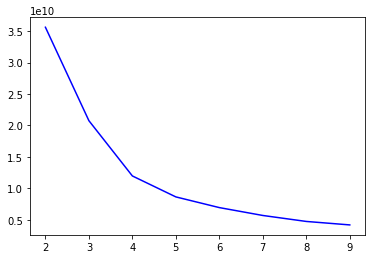

In [24]:
plt.plot(x,y,color='blue')
plt.show()
#plt.plot(x,sil_y[:12],color='green')


In [25]:
pop_kmeans=kmeans(pop_pca_df,n_clusters=8)

In [26]:
len(pop_kmeans.cluster_centers_),
labels=pop_kmeans.labels_
total=labels.shape[0]
pop_p=[(labels==0).sum()/total *100,
(labels==1).sum()/total *100,
(labels==2).sum()/total *100,
(labels==3).sum()/total *100,
(labels==4).sum()/total *100,
(labels==5).sum()/total *100,
(labels==6).sum()/total *100,
(labels==7).sum()/total *100,]


In [27]:
cust_pred_labels=pop_kmeans.predict(cust_pca_df)

labels=cust_pred_labels
total=labels.shape[0]
cust_p=[(labels==0).sum()/total *100,
(labels==1).sum()/total *100,
(labels==2).sum()/total *100,
(labels==3).sum()/total *100,
(labels==4).sum()/total *100,
(labels==5).sum()/total *100,
(labels==6).sum()/total *100,
(labels==7).sum()/total *100,]

([20.912770233196927,
  10.025796070783789,
  1.1926334769939217,
  29.962714074286851,
  3.6550978937884095,
  13.105503573187796,
  14.63351963205535,
  6.5119650457069582],
 [15.6940705027863,
  9.4478534009558999,
  1.1693068686995178,
  16.432387869680461,
  3.5919270344165461,
  33.811282950347504,
  13.366935904660531,
  6.4862354684532386])

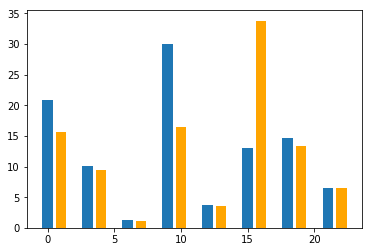

In [28]:
plt.bar(range(0,22,3),pop_p);
plt.bar(range(1,24,3),cust_p,color='orange');
#plt.xticks(np.arange(8))
pop_p,cust_p

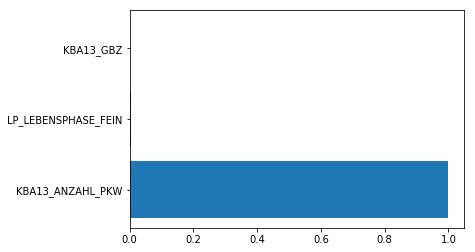

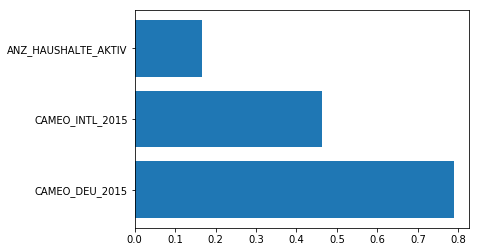

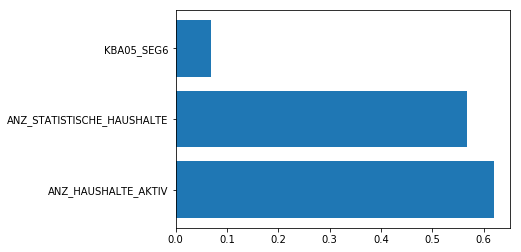

In [76]:
#comps_df=pd.DataFrame(pop_pca.components_,columns=azdias.columns.tolist())
v=comps_df.iloc[0].sort_values(ascending=False)[:3]
i=v.index.tolist()
j=v.values.astype('float').tolist()
plt.barh(range(len(i)),j,tick_label=i);
plt.show()
v=comps_df.iloc[1].sort_values(ascending=False)[:3]
i=v.index.tolist()
j=v.values.astype('float').tolist()
plt.barh(range(len(i)),j,tick_label=i);
plt.show()
v=comps_df.iloc[2].sort_values(ascending=False)[:3]
i=v.index.tolist()
j=v.values.astype('float').tolist()
plt.barh(range(len(i)),j,tick_label=i);
plt.show()

In [66]:
azdias.CAMEO_DEU_2015

0         -1.0
1         80.0
2         42.0
3         20.0
4         61.0
5         82.0
6         40.0
7         23.0
8         10.0
9         14.0
10        93.0
11        -1.0
12        61.0
13        52.0
14        -1.0
15        81.0
16        70.0
17        -1.0
18        42.0
19        53.0
20        42.0
21        94.0
22        93.0
23        61.0
24        -1.0
25        52.0
26        -1.0
27        91.0
28        10.0
29        20.0
          ... 
891191    62.0
891192    51.0
891193    61.0
891194    42.0
891195    83.0
891196    41.0
891197    32.0
891198    22.0
891199    80.0
891200    90.0
891201    70.0
891202    81.0
891203    33.0
891204    32.0
891205    54.0
891206    33.0
891207    70.0
891208    22.0
891209    80.0
891210    81.0
891211    93.0
891212    93.0
891213    54.0
891214    30.0
891215    50.0
891216    70.0
891217    93.0
891218    42.0
891219    93.0
891220    61.0
Name: CAMEO_DEU_2015, Length: 891221, dtype: float64

num_cols=len(azdias.columns)
#(azdias.iloc[0:500000,:].isnull().sum(axis=1)/num_cols > 0.4).sum()
#not_null_cols=not_null_cols(azdias)
#len(not_null_cols),num_cols
#azdias.columns[azdias.isnull().any()]
#azdias[np.isnan(azdias.ANZ_HAUSHALTE_AKTIV)]
#numeric_cols=['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE']

#med=azdias['ANZ_HAUSHALTE_AKTIV'].median()
#azdias['ANZ_HAUSHALTE_AKTIV'].replace(np.nan,med).value_counts(dropna=False)

replace_nan(azdias,numeric_cols)

#azdias[np.isnan(azdias.ANZ_STATISTISCHE_HAUSHALTE)]

In [6]:
azdias.AGER_TYP.value_counts(),customers.AGER_TYP.value_counts(),\
azdias.ANREDE_KZ.value_counts(),customers.ANREDE_KZ.value_counts(),

(-1    677503
  2     98472
  1     79802
  3     27104
  0      8340
 Name: AGER_TYP, dtype: int64, -1    92107
  2    45874
  1    40382
  3     8658
  0     4631
 Name: AGER_TYP, dtype: int64, 2    465305
 1    425916
 Name: ANREDE_KZ, dtype: int64, 1    119508
 2     72144
 Name: ANREDE_KZ, dtype: int64)

In [ ]:
azdias

36
0.826814016545
36
0.939228486621


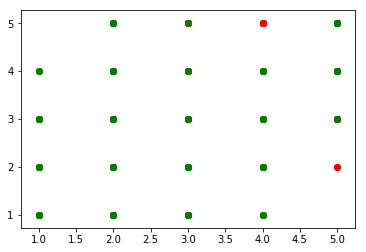

In [59]:
#plt.scatter(customers.AGER_TYP[:1000],customers.ANREDE_KZ[:1000])
#customers.ANZ_PERSONEN.value_counts()
#azdias.FINANZ_MINIMALIST.value_counts()
from sklearn.decomposition import PCA

finance_df_pop=azdias.filter(regex='(?i)(.*FINANZ.*)')
finance_df_cust=customers.filter(regex='(?i)(.*FINANZ.*)')

def diff_cols(df1,df2):
    print("population")
    for col in df1.columns.tolist():
        print(df1[col].value_counts()/df1.shape[0] * 100.0)
    print("cust")
    for col in df2.columns.tolist():
        print(df2[col].value_counts()/df2.shape[0] * 100.0)
        

def unique_cols(df1,df2):
    print("population")
    for col in df1.columns.tolist():
        print(col)
        print(df1[col].nunique())
        print(df1[col].unique())
    print("cust")
    for col in df2.columns.tolist():
        print(col)
        print(df2[col].nunique())
        print(df1[col].unique())


plt.scatter(finance_df_pop.FINANZ_ANLEGER[:500],finance_df_pop.FINANZ_SPARER[:500],color='red')
plt.scatter(finance_df_customers.FINANZ_ANLEGER[:500],finance_df_customers.FINANZ_SPARER[:500],color='green')
    
#finance_df_pop_dummied.corr()
def finance_pca(df):
    pca=PCA(n_components=15)
    X=pca.fit_transform(df)
    #print(X)
    #print(pca.explained_variance_ratio_)
    sum=0
    for val in pca.explained_variance_ratio_:
        sum+=val
    print(sum)

#diff_cols(finance_df_pop,finance_df_customers)

finance_df_pop_dummied=get_dumm(finance_df_pop)
finance_df_cust_dummied=get_dumm(finance_df_cust)

print(len(finance_df_pop_dummied.columns))
finance_pca(finance_df_pop_dummied)
print(len(finance_df_cust_dummied.columns))
finance_pca(finance_df_cust_dummied)


In [62]:
semio_df_pop=azdias.filter(regex='(?i)(.*SEMIO.*)')
semio_df_cust=customers.filter(regex='(?i)(.*SEMIO.*)')
#diff_cols(semio_df_pop,semio_df_cust)

semio_df_cust.SEMIO_SOZ.nunique()/semio_df_cust.shape[0] *100 

azdias.GEBURTSJAHR.unique()
azdias.GREEN_AVANTGARDE.unique()
person_cols=['AGER_TYP'
,'ALTERSKATEGORIE_GROB'
,'ANREDE_KZ'
,'CJT_GESAMTTYP'
,'FINANZ_MINIMALIST'
,'FINANZ_SPARER'
,'FINANZ_VORSORGER'
,'FINANZ_ANLEGER'
,'FINANZ_UNAUFFAELLIGER'
,'FINANZ_HAUSBAUER'
,'FINANZTYP'
,'GEBURTSJAHR'
,'GFK_URLAUBERTYP'
,'GREEN_AVANTGARDE'
,'HEALTH_TYP'
,'LP_LEBENSPHASE_FEIN'
,'LP_LEBENSPHASE_GROB'
,'LP_FAMILIE_FEIN'
,'LP_FAMILIE_GROB'
,'LP_STATUS_FEIN'
,'LP_STATUS_GROB'
,'NATIONALITAET_KZ'
,'PRAEGENDE_JUGENDJAHRE'
,'RETOURTYP_BK_S'
,'SEMIO_SOZ'
,'SEMIO_FAM'
,'SEMIO_REL'
,'SEMIO_MAT'
,'SEMIO_VERT'
,'SEMIO_LUST'
,'SEMIO_ERL'
,'SEMIO_KULT'
,'SEMIO_RAT'
,'SEMIO_KRIT'
,'SEMIO_DOM'
,'SEMIO_KAEM'
,'SEMIO_PFLICHT'
,'SEMIO_TRADV'
,'SHOPPER_TYP'
,'TITEL_KZ'
,'VERS_TYP'
,'ZABEOTYP']
person_df_pop=azdias[person_cols]
person_df_cust=customers[person_cols]
unique_cols(person_df_pop,person_df_cust)
diff_cols(person_df_pop,person_df_cust)

population
AGER_TYP
5
[-1  2  3  0  1]
ALTERSKATEGORIE_GROB
5
[2 1 3 4 9]
ANREDE_KZ
2
[1 2]
CJT_GESAMTTYP
6
[  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST
5
[3 1 4 2 5]
FINANZ_SPARER
5
[4 5 2 3 1]
FINANZ_VORSORGER
5
[3 2 1 5 4]
FINANZ_ANLEGER
5
[5 2 1 4 3]
FINANZ_UNAUFFAELLIGER
5
[5 4 3 1 2]
FINANZ_HAUSBAUER
5
[3 5 2 4 1]
FINANZTYP
6
[4 1 6 5 2 3]
GEBURTSJAHR
117
[   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965 1969
 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926 1954 1981 1962
 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938 1945 1942 1984 1930
 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929 1939 2001 1995 1956 1953
 2012 1934 1913 1914 1922 2004 1936 2009 1915 2003 2013 1998 2007 1932 2005
 1923 1925 2015 1933 2017 2000 1999 2014 1920 1918 1924 2016 2011 1908 1919
 1916 1917 1912 1911 1909 1910 1904 1906 1905 1900 1907 1902]
GFK_URLAUBERTYP
12
[ 10.   1.   

In [26]:
customers.CUSTOMER_GROUP.value_counts(),customers.ONLINE_PURCHASE.value_counts(),customers.PRODUCT_GROUP.value_counts()
#, 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

azdias.D19_BANKEN_DIREKT.value_counts(),customers.D19_BANKEN_DIREKT.value_counts(),

azdias[0:10].describe()
for col  in azdias.select_dtypes('object').columns:
    print(azdias[col].value_counts())
    



6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43

In [28]:
pd.to_datetime(azdias.EINGEFUEGT_AM)
#azdias.EINGEFUEGT_AM

0                         NaN
1         1992-02-10 00:00:00
2         1992-02-12 00:00:00
3         1997-04-21 00:00:00
4         1992-02-12 00:00:00
5         1992-02-12 00:00:00
6         1992-02-12 00:00:00
7         1992-02-10 00:00:00
8         1992-02-10 00:00:00
9         1992-02-10 00:00:00
10        1992-02-10 00:00:00
11                        NaN
12        2005-12-30 00:00:00
13        2009-01-19 00:00:00
14                        NaN
15        1992-02-12 00:00:00
16        1995-02-02 00:00:00
17                        NaN
18        1996-12-05 00:00:00
19        1992-02-12 00:00:00
20        2002-03-13 00:00:00
21        1992-02-12 00:00:00
22        1992-02-10 00:00:00
23        1992-02-12 00:00:00
24                        NaN
25        1992-02-12 00:00:00
26        2015-04-01 00:00:00
27        1996-05-09 00:00:00
28        1992-02-12 00:00:00
29        2005-04-12 00:00:00
                 ...         
891191    1992-02-10 00:00:00
891192    1992-02-12 00:00:00
891193    

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()
customers.head()
azdias.dtypes.index.tolist()
azdias.dtypes
azdias


LNR                             int64
AGER_TYP                        int64
AKT_DAT_KL                    float64
ALTER_HH                      float64
ALTER_KIND1                   float64
ALTER_KIND2                   float64
ALTER_KIND3                   float64
ALTER_KIND4                   float64
ALTERSKATEGORIE_FEIN          float64
ANZ_HAUSHALTE_AKTIV           float64
ANZ_HH_TITEL                  float64
ANZ_KINDER                    float64
ANZ_PERSONEN                  float64
ANZ_STATISTISCHE_HAUSHALTE    float64
ANZ_TITEL                     float64
ARBEIT                        float64
BALLRAUM                      float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                 float64
CJT_KATALOGNUTZER             float64
CJT_TYP_1                     float64
CJT_TYP_2                     float64
CJT_TYP_3                     float64
CJT_TYP_4                     float64
CJT_TYP_5   

In [67]:
azdias.CAMEO_DEU_2015.unique(),azdias.CAMEO_DEUG_2015.unique(),azdias.CAMEO_INTL_2015.unique()

(array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
        '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
        '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
        '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
        '1C', 'XX'], dtype=object),
 array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
        '2', '8', '9', '6', '5', '1', 'X'], dtype=object),
 array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
        41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
        '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
        '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object))

In [ ]:
customers.CAMEO_DEU_2015.unique(),customers.CAMEO_DEUG_2015.unique(),customers.CAMEO_INTL_2015.unique()

In [31]:
#azdias.shape
#azdias[:100000]
azdias.select_dtypes('object').columns
azdias.CAMEO_DEU_2015.value_counts()
azdias[azdias.CAMEO_DEU_2015== 'XX'].head()
#from sklearn.decomposition import PCA
#PCA = PCA(n_components=50)
#trx=PCA.fit_transform(azdias[:1000])

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2511,880176,-1,1.0,15.0,NaN,NaN,NaN,NaN,15.0,1.0,...,NaN,3.0,6.0,6.0,3.0,6.0,2.0,2,2,2
4569,226236,-1,5.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,NaN,3.0,6.0,6.0,3.0,9.0,5.0,2,2,3
9803,507931,2,5.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,4.0,6.0,3.0,6.0,9.0,3.0,1,2,4
16700,641123,3,4.0,0.0,NaN,NaN,NaN,NaN,11.0,1.0,...,4.0,8.0,4.0,2.0,3.0,9.0,3.0,3,2,3
16883,390003,2,3.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,5.0,6.0,3.0,6.0,9.0,3.0,4,2,4


In [13]:
#azdias.columns[~azdias.isnull().any()].tolist() ,customers.columns[~customers.isnull().any()].tolist()
#len(customers.columns.tolist())

#azdias.columns[~azdias.isnull().any()]
# azdias.isnull().all().tolist()
# No column is completely Null
azdias.columns[azdias.isnull().sum()/azdias.shape[0] *100.0 > 70 ]

#customers.columns[customers.isnull().sum()/customers.shape[0] *100.0 > 50 ]
#customers.KK_KUNDENTYP.unique()

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992'],
      dtype='object')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

(891221, 366)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [122]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
u2=union_cols.tolist()
u2.append('RESPONSE')

In [124]:
mailout_train=transform_train(mailout_train,u2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [108]:
#convert_cols(mailout_train)
#pop_pca.transform(mailout_train[mailout_train.RESPONSE==1])
#mailout_train.RESPONSE.value_counts(dropna=False)


#seg_entropy(mailout_train[mailout_train.RESPONSE==1],'ALTER_KIND1',dropna=False),seg_entropy(mailout_train[mailout_train.RESPONSE==0],'ALTER_KIND1',dropna=False)

In [125]:
def predict(train_pos):
    train_positive_df=pop_pca.transform(train_pos)
    labels=pop_kmeans.predict(train_positive_df)
    total=labels.shape[0]
    train_pos_p=[(labels==0).sum()/total *100,
    (labels==1).sum()/total *100,
    (labels==2).sum()/total *100,
    (labels==3).sum()/total *100,
    (labels==4).sum()/total *100,
    (labels==5).sum()/total *100,
    (labels==6).sum()/total *100,
    (labels==7).sum()/total *100,]
    plt.bar(range(1,24,3),train_pos_p,color='orange');

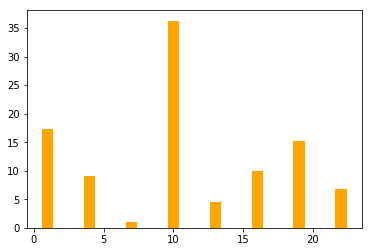

In [126]:
train_positive=mailout_train[mailout_train.RESPONSE==1]
train_pos=train_positive.drop('RESPONSE',axis=1)
predict(train_pos)

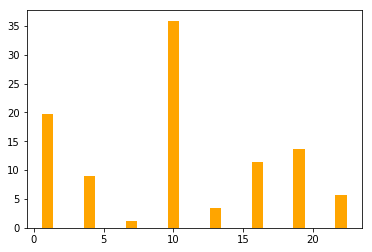

In [127]:
train_negative=mailout_train[mailout_train.RESPONSE==0]
train_neg=train_negative.drop('RESPONSE',axis=1)
predict(train_neg)


In [201]:
#!pip install imbalanced-learn==0.8.0
!pip uninstall -y imbalanced-learn
import imblearn
print(imblearn.__version__)
import sklearn
#print(np.__version__)
print(sklearn.__version__)

Uninstalling imbalanced-learn-0.6.0:
  Successfully uninstalled imbalanced-learn-0.6.0
0.4.3
0.19.1


In [202]:
import sys
!{sys.executable} -m pip install imbalanced-learn==0.4.3

  Using cached https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl


In [203]:
#from sklearn.utils import safe_indexing
from imblearn.over_sampling import SMOTE

In [205]:
from sklearn.linear_model import LogisticRegression
X=mailout_train.drop('RESPONSE',axis=1)
y=mailout_train.RESPONSE


In [206]:
lr=LogisticRegression(class_weight='balanced')
lr.fit(X,y)
lr.score(X,y)

0.72140496252502206

In [211]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
pred=lr.predict(X)
print(classification_report(y,pred))
print(roc_auc_score(y,pred))

             precision    recall  f1-score   support

          0       0.99      0.72      0.84     42430
          1       0.03      0.70      0.06       532

avg / total       0.98      0.72      0.83     42962

0.709537380453


In [209]:
smote=SMOTE(random_state=10)
x_smote,y_smote=smote.fit_resample(X,y)

In [215]:
x_smote.shape,y_smote.sum()

((84860, 221), 42430)

In [210]:
lr_smote=LogisticRegression()
lr_smote.fit(x_smote,y_smote)
lr_smote.score(x_smote,y_smote)
pred=lr_smote.predict(X)
print(classification_report(y,pred))
print(roc_auc_score(y,pred))

0.72724487390996939

In [222]:
from sklearn.ensemble import AdaBoostClassifier
abc=AdaBoostClassifier()
abc.fit(x_smote,y_smote)
pred=abc.predict(X)
print(classification_report(y,pred))
print(roc_auc_score(y,pred))

ImportError: cannot import name '_print_elapsed_time'

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [128]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
mailout_test=transform_train(mailout_test,union_cols)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


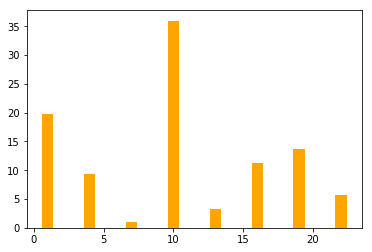

In [135]:
predict(mailout_test)

In [159]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
pred=lr.predict(mailout_test)
pred.sum()/len(pred) *100.0

28.330959774006025

In [214]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
pred=lr_smote.predict(mailout_test)
pred.sum()/len(pred) *100.0

26.80876893983611